In [26]:
pip install pyLDAvis

  Stored in directory: C:\Users\LeeJeungHun\AppData\Local\pip\Cache\wheels\98\71\24\513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
from nltk import wordpunct_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import string

import textblob as tb
from tqdm import tqdm

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

In [3]:
# 데이터 읽기

# colnames = ['comment', 'like', 'dislike', 'month']
colnames = ['title']
# df = pd.read_csv('/content/gdrive/My Drive/Dongkuk_project/토막글 생성/LSTM/naver/naver_comments.csv')
df = pd.read_csv('naver_titles_0701_0710.csv', encoding='utf-8', header=None, names=colnames)

df.columns
print(df.head())
print(len(df))

                                         title
0                            독이 된 황교안의 ‘가벼운 입’
1  “Fantastic Woman” 틈만 나면 김정숙 여사 특급 칭찬한 트럼프 …
2                              강효상 ‘빗나간 예측’ 망신
3      "민주당, 나경원 살리고 심상정 버렸다" 정의당 반발에… 與, 공조 …
4             탁현민 "준비안된 남북미 만남…인공기·성조기 바닥에 끌려"
300


In [4]:
df = df.loc[:29]

In [5]:
df['title'].isnull().values.any()

False

In [6]:
# 한글 단어 바꾸기
def change_string(x):
    return x.replace('靑','청와대').replace('軍','군대').replace('北','북한').replace('美','미국').replace('日','일본').replace('韓', '한국').replace('與', '여당').replace('野', '야당').replace('中', '중국').replace('黃', '황교안')

In [7]:
df['title'] = df['title'].map(lambda x : change_string(x))

In [8]:
news_title = [] # 리스트 선언
news_title.extend(list(df.title.values)) # 헤드라인의 값들을 리스트로 저장
# news_title = [n for n in news_title if len(n) >=10]
len(news_title) # 제거 후 샘플의 개수

30

In [9]:
from string import punctuation
import re

def clean_text(text):
#     cleaned_text = [''.join(c for c in text).lower()]
#     cleaned_text = re.sub('[^가-힣a-zA-Z文 ]', '', text)
    cleaned_text = re.sub('[0-9]', ' ', text)
    cleaned_text = re.sub('[\{\}\[\]\/?.,;:|\)*~`!^\-_+<>@\#$%&\\\=\(\'\"\'\·]',
                          ' ', cleaned_text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    return cleaned_text

In [11]:
text = [clean_text(x) for x in news_title]
text = pd.DataFrame(text, columns=['title'])
text[:10]

,title
0,독이 된 황교안의 ‘가벼운 입’
1,“Fantastic Woman” 틈만 나면 김정숙 여사 특급 칭찬한 트럼프 …
2,강효상 ‘빗나간 예측’ 망신
3,민주당 나경원 살리고 심상정 버렸다 정의당 반발에… 여당 공조 …
4,탁현민 준비안된 남북미 만남…인공기 성조기 바닥에 끌려
5,남북미 판문점 회동 이방카 김여정 한자리에…MDL 찾은 이방카 …
6,여당에 뿔난 정의당 앞으로 돕는일 없다 …범진보진영 역풍 우려 종…
7,나경원 文 운전자에서 객 으로 전락…통미봉남 고착화 우려
8,한국당 지도부 일제히 트럼프 비판 자국우선주의
9,트럼프 말 끝나자마자 손짓 주목받은 김정은 영어실력


In [12]:
from konlpy.tag import Komoran
#형태소 분석기 
komoran = Komoran(userdic='./user_dic.txt')
text['title'] = text.apply(lambda row: komoran.nouns(row['title']), axis=1)
text.head()
# text.to_csv('noun.csv', encoding='utf-8')

,title
0,"[독, 황교안, 입]"
1,"[틈, 김정숙, 여사, 특급, 칭찬, 트럼프]"
2,"[강, 효, 예측, 망신]"
3,"[민주당, 나경원, 심상정, 정의당, 반발, 여당, 공조]"
4,"[탁현민, 준비, 안, 남북, 미, 만남, 인공, 성조기, 바닥]"


In [13]:
stop_words = ['신문', '종합', '단독', '상보', '속보', '것', '뉴스', '내일']
text['title'] = text['title'].apply(lambda x: [word for word in x
                                                    if word not in stop_words 
                                                    ])
text.head()

,title
0,"[독, 황교안, 입]"
1,"[틈, 김정숙, 여사, 특급, 칭찬, 트럼프]"
2,"[강, 효, 예측, 망신]"
3,"[민주당, 나경원, 심상정, 정의당, 반발, 여당, 공조]"
4,"[탁현민, 준비, 안, 남북, 미, 만남, 인공, 성조기, 바닥]"


In [15]:
# 한글짜 지우기
tokenized_doc = text['title'].apply(lambda x: [word for word in x if len(word) >1])
tokenized_doc.head()

0                               [황교안]
1              [김정숙, 여사, 특급, 칭찬, 트럼프]
2                            [예측, 망신]
3    [민주당, 나경원, 심상정, 정의당, 반발, 여당, 공조]
4      [탁현민, 준비, 남북, 만남, 인공, 성조기, 바닥]
Name: title, dtype: object

In [17]:
# 역 토큰화

documents = []
for i in range(len(text)):
    t = ' '.join(tokenized_doc[i])
    documents.append(t)
    
documents[:5]

['황교안',
 '김정숙 여사 특급 칭찬 트럼프',
 '예측 망신',
 '민주당 나경원 심상정 정의당 반발 여당 공조',
 '탁현민 준비 남북 만남 인공 성조기 바닥']

blahblah

In [69]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [70]:
id2word = corpora.Dictionary(tokenized_doc)

texts = tokenized_doc

corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1])

[[(0, 1)]]


In [71]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('황교안', 1)]]

In [72]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=7,
                                           alpha='auto',
                                           per_word_topics=True)

In [73]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.074*"트럼프" + 0.039*"한국당" + 0.039*"예측" + 0.039*"지도부" + 0.039*"우선주" + '
  '0.039*"비판" + 0.039*"여사" + 0.039*"칭찬" + 0.039*"다행" + 0.039*"특급"'),
 (1,
  '0.065*"성조기" + 0.044*"남북" + 0.044*"이방" + 0.044*"탁현민" + 0.044*"바닥" + '
  '0.023*"황교안" + 0.023*"판문점" + 0.023*"준비" + 0.023*"김여정" + 0.023*"회동"'),
 (2,
  '0.054*"고착" + 0.054*"나경원" + 0.054*"미봉" + 0.054*"전락" + 0.054*"우려" + '
  '0.054*"운전자" + 0.054*"예측" + 0.054*"망신" + 0.005*"황교안" + 0.005*"트럼프"'),
 (3,
  '0.042*"불명" + 0.042*"전투기" + 0.042*"선희" + 0.042*"확인" + 0.042*"교체" + '
  '0.042*"리용호" + 0.042*"하노이" + 0.042*"부전선" + 0.042*"정체" + 0.042*"상항"'),
 (4,
  '0.059*"부전선" + 0.059*"포착" + 0.059*"합참" + 0.031*"불명" + 0.031*"수출" + '
  '0.031*"정체" + 0.031*"핵심" + 0.031*"상항" + 0.031*"규제" + 0.031*"레이더"'),
 (5,
  '0.090*"김정은" + 0.090*"트럼프" + 0.047*"영어" + 0.047*"손짓" + 0.047*"귓속말" + '
  '0.047*"회담" + 0.047*"주목" + 0.047*"실력" + 0.047*"판문점" + 0.004*"황교안"'),
 (6,
  '0.057*"반발" + 0.057*"민주당" + 0.057*"공조" + 0.057*"나경원" + 0.057*"심상정" + '
  '0.057*"여당" + 0.057*"정의당" + 0.00

In [74]:
a_0=lda_model.print_topics()[0]
a_1=lda_model.print_topics()[1]
a_2=lda_model.print_topics()[2]
a_3=lda_model.print_topics()[3]
a_4=lda_model.print_topics()[4]
a_5=lda_model.print_topics()[5]
a_6=lda_model.print_topics()[6]
a_7=lda_model.print_topics()[7]
a_8=lda_model.print_topics()[8]
a_9=lda_model.print_topics()[9]
L_0=list(a_0)
L_1=list(a_1)
L_2=list(a_2)
L_3=list(a_3)
L_4=list(a_4)
L_5=list(a_5)
L_6=list(a_6)
L_7=list(a_7)
L_8=list(a_8)
L_9=list(a_9)
L_0[0]='트럼프 여사 칭찬'
L_1[0]='성조기 바닥'
L_2[0]='나경원 전략'
L_3[0]='북한 전략'
L_4[0]='미확인 물체'
L_5[0]='김정은 영어 '
L_6[0]='트럼프 '
L_7[0]='트럼프 '
L_8[0]='트럼프 '
L_9[0]='트럼프 '
t_0 = tuple(L_0)
t_1 = tuple(L_1)
t_2 = tuple(L_2)
t_3 = tuple(L_3)
t_4 = tuple(L_4)
t_5 = tuple(L_5)
t_6 = tuple(L_6)
t_7 = tuple(L_7)
t_8 = tuple(L_8)
t_9 = tuple(L_9)

T=[t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9]


lda_model=T

In [78]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_doc, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

AttributeError: 'list' object has no attribute 'log_perplexity'

In [79]:
lda_model

[('트럼프 여사 칭찬',
  '0.074*"트럼프" + 0.039*"한국당" + 0.039*"예측" + 0.039*"지도부" + 0.039*"우선주" + 0.039*"비판" + 0.039*"여사" + 0.039*"칭찬" + 0.039*"다행" + 0.039*"특급"'),
 ('성조기 바닥',
  '0.065*"성조기" + 0.044*"남북" + 0.044*"이방" + 0.044*"탁현민" + 0.044*"바닥" + 0.023*"황교안" + 0.023*"판문점" + 0.023*"준비" + 0.023*"김여정" + 0.023*"회동"'),
 ('나경원 전략',
  '0.054*"고착" + 0.054*"나경원" + 0.054*"미봉" + 0.054*"전락" + 0.054*"우려" + 0.054*"운전자" + 0.054*"예측" + 0.054*"망신" + 0.005*"황교안" + 0.005*"트럼프"'),
 ('북한 전략',
  '0.042*"불명" + 0.042*"전투기" + 0.042*"선희" + 0.042*"확인" + 0.042*"교체" + 0.042*"리용호" + 0.042*"하노이" + 0.042*"부전선" + 0.042*"정체" + 0.042*"상항"'),
 ('미확인 물체',
  '0.059*"부전선" + 0.059*"포착" + 0.059*"합참" + 0.031*"불명" + 0.031*"수출" + 0.031*"정체" + 0.031*"핵심" + 0.031*"상항" + 0.031*"규제" + 0.031*"레이더"'),
 ('김정은 영어 ',
  '0.090*"김정은" + 0.090*"트럼프" + 0.047*"영어" + 0.047*"손짓" + 0.047*"귓속말" + 0.047*"회담" + 0.047*"주목" + 0.047*"실력" + 0.047*"판문점" + 0.004*"황교안"'),
 ('트럼프 ',
  '0.057*"반발" + 0.057*"민주당" + 0.057*"공조" + 0.057*"나경원" + 0.057*"심상정" + 0.057*"여당" + 0.0

In [51]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\LeeJeungHun\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.177139 -0.098681       1        1  19.352898
7     -0.084013  0.099943       2        1  15.575706
4     -0.120996 -0.121322       3        1  12.966569
9     -0.042732  0.067323       4        1  10.265878
0      0.049978  0.053096       5        1   9.126647
8      0.057809  0.053203       6        1   8.764819
3     -0.113873 -0.070767       7        1   8.196049
5      0.024434  0.077160       8        1   6.493983
2      0.023405 -0.024011       9        1   4.820473
6      0.028850 -0.035943      10        1   4.436975, topic_info=    Category      Freq Term     Total  loglift  logprob
4    Default  5.000000  트럼프  5.000000  30.0000  30.0000
41   Default  2.000000  김정은  2.000000  29.0000  29.0000
9    Default  1.000000  나경원  1.000000  28.0000  28.0000
62   Default  2.000000   합참  2.000000  27.0000  27.0000
59   Default  2.000000  부전선  2.000000  26.0000  26.0000
61   Default  2.000000   포착  2.000000  25.0000  25.0000
13   Default  1.000000   여당  1.000000  24.0000  24.0000
14   Default  1.000000  정의당  1.000000  23.0000  23.0000
7    Default  1.000000   예측  1.000000  22.0000  22.0000
29   Default  1.000000   우려  1.000000  21.0000  21.0000
25   Default  3.000000  판문점  3.000000  20.0000  20.0000
44   Default  1.000000   영어  1.000000  19.0000  19.0000
43   Default  1.000000   실력  1.000000  18.0000  18.0000
18   Default  2.000000  성조기  2.000000  17.0000  17.0000
10   Default  0.000000  민주당  0.000000  16.0000  16.0000
11   Default  0.000000   반발  0.000000  15.0000  15.0000
8    Default  0.000000   공조  0.000000  14.0000  14.0000
12   Default  0.000000  심상정  0.000000  13.0000  13.0000
21   Default  2.000000  탁현민  2.000000  12.0000  12.0000
32   Default  0.000000   고착  0.000000  11.0000  11.0000
33   Default  0.000000   미봉  0.000000  10.0000  10.0000
35   Default  0.000000   전락  0.000000   9.0000   9.0000
34   Default  0.000000  운전자  0.000000   8.0000   8.0000
6    Default  0.000000   망신  0.000000   7.0000   7.0000
15   Default  2.000000   남북  2.000000   6.0000   6.0000
50   Default  3.000000   불명  3.000000   5.0000   5.0000
53   Default  3.000000   정체  3.000000   4.0000   4.0000
60   Default  1.000000   상항  1.000000   3.0000   3.0000
52   Default  1.000000  전투기  1.000000   2.0000   2.0000
49   Default  1.000000   북한  1.000000   1.0000   1.0000
..       ...       ...  ...       ...      ...      ...
106  Topic10  0.040024   관의  1.118375  -0.2149  -5.2679
109  Topic10  0.040024   통역  1.118375  -0.2149  -5.2679
107  Topic10  0.040024   영상  1.118375  -0.2149  -5.2679
65   Topic10  0.040024   시즌  1.118375  -0.2149  -5.2679
63   Topic10  0.040024   다리  1.118375  -0.2149  -5.2679
66   Topic10  0.040024   연출  1.118375  -0.2149  -5.2679
108  Topic10  0.040024   인정  1.118375  -0.2149  -5.2679
64   Topic10  0.040024   도보  1.118376  -0.2149  -5.2679
0    Topic10  0.040025  황교안  2.620468  -1.0664  -5.2678
4    Topic10  0.040025  트럼프  5.162800  -1.7445  -5.2678
25   Topic10  0.040025  판문점  3.517639  -1.3609  -5.2679
7    Topic10  0.040025   예측  1.534480  -0.5313  -5.2679
62   Topic10  0.040024   합참  2.375324  -0.9682  -5.2679
21   Topic10  0.040024  탁현민  2.547388  -1.0381  -5.2679
41   Topic10  0.040024  김정은  2.680659  -1.0891  -5.2679
61   Topic10  0.040024   포착  2.375324  -0.9682  -5.2679
53   Topic10  0.040024   정체  3.008246  -1.2044  -5.2679
18   Topic10  0.040024  성조기  2.702104  -1.0971  -5.2679
50   Topic10  0.040024   불명  3.008246  -1.2044  -5.2679
1    Topic10  0.040024  김정숙  1.799646  -0.6907  -5.2679
87   Topic10  0.040024   우리  1.273082  -0.3445  -5.2679
97   Topic10  0.040024   언급  1.237265  -0.3160  -5.2679
59   Topic10  0.040024  부전선  2.375324  -0.9682  -5.2679
60   Topic10  0.040024   상항  1.738598  -0.6561  -5.2679
17   Topic10  0.040024   바닥  1.987593  -0.7900  -5.2679
15   Topic10  0.040024   남북  2.549974  -1.0392  -5.2679
23   Topic10  0.040024  김여정  1.864045  -0.7258  -5.2679
29   

In [40]:
import os
from gensim.models.wrappers import LdaMallet

# os.environ['MALLET_HOME'] = 'C:\\Users\\camel\\mallet-2.0.8'
os.environ['MALLET_HOME'] = 'C:/Users/LeeJeungHun/Desktop/데이터_프로젝트/drive-download-20190824T053948Z-001/mallet-2.0.8'

# mallet_path = 'C:/Users/camel/mallet-2.0.8/bin/mallet'
mallet_path = 'C:/Users/LeeJeungHun/Desktop/데이터_프로젝트/drive-download-20190824T053948Z-001/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=4, id2word=id2word)

In [41]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [42]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=tokenized_doc, start=1, limit=25, step=3)

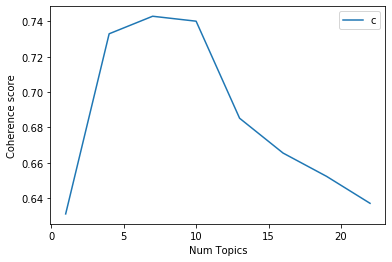

In [43]:
# Show graph
limit = 25; start=1; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

In [44]:
for m, cv in zip(x, coherence_values):
    print('Num Topics =', m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.6311
Num Topics = 4  has Coherence Value of 0.733
Num Topics = 7  has Coherence Value of 0.743
Num Topics = 10  has Coherence Value of 0.7402
Num Topics = 13  has Coherence Value of 0.6852
Num Topics = 16  has Coherence Value of 0.6655
Num Topics = 19  has Coherence Value of 0.6523
Num Topics = 22  has Coherence Value of 0.6371


blahblah

In [45]:
!pip install kiwipiepy

In [51]:
from kiwipiepy import Kiwi
 
kiwi = Kiwi()
kiwi.prepare()
 
# tokenize 함수를 정의합니다. 한국어 문장을 입력하면 형태소 단위로 분리하고,
# 불용어 및 특수 문자 등을 제거한 뒤, list로 반환합니다.
def tokenize(sent):
    res, score = kiwi.analyze(sent)[0] # 첫번째 결과를 사용
    return [word + ('다' if tag.startswith('V') else '') # 동사에는 '다'를 붙여줌
            for word, tag, _, _ in res
            if not tag.startswith('E') and not tag.startswith('J') and not tag.startswith('S')] # 조사, 어미, 특수기호는 제거


In [52]:
from kiwipiepy import Kiwi
 
kiwi = Kiwi()
kiwi.prepare()
stopwords = set(["사람", "것"])
# tokenize 함수를 정의합니다. 한국어 문장을 입력하면 형태소 단위로 분리하고,
# 불용어 및 특수 문자 등을 제거한 뒤, list로 반환합니다.
def tokenize(sent):
    res, score = kiwi.analyze(sent)[0] # 첫번째 결과를 사용
    return [word + ('다' if tag.startswith('V') else '') # 동사에는 '다'를 붙여줌
            for word, tag, _, _ in res
            if not tag.startswith('E') and not tag.startswith('J') and not tag.startswith('S') and word not in stopwords] # 조사, 어미, 특수기호 및 stopwords에 포함된 단어는 제거


In [47]:
from kiwipiepy import Kiwi
 
kiwi = Kiwi()
kiwi.prepare()
stopwords = set(["사람", "것"])
# tokenize 함수를 정의합니다. 한국어 문장을 입력하면 형태소 단위로 분리하고,
# 불용어 및 특수 문자 등을 제거한 뒤, list로 반환합니다.
def tokenize(sent):
    res, score = kiwi.analyze(sent)[0] # 첫번째 결과를 사용
    return [word + ('다' if tag.startswith('V') else '') # 동사에는 '다'를 붙여줌
            for word, tag, _, _ in res
            if tag.startswith('N') and word not in stopwords] # 조사, 어미, 특수기호 및 stopwords에 포함된 단어는 제거


In [48]:
tokenize(df.title[3])

['민주당', '나경원', '심상정', '정의당', '반발', '여당', '공조']